# Comparison of metrics

In this notebook, we compare the readability scores computed with our metrics with those computed using the python library `textstat`.

In [1]:
# Run when first starting up notebook
!pip install textstat

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import textstat
from typing import List

# Plot settings for retina
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Constants
max_len = 670
raw_data_file = "raw_data.json"

In [4]:
# Function to load data
def load_raw_data(in_file):
    with open(in_file) as f:
        data = json.load(f)
        df = pd.json_normalize(data)

    df['from.text'] = df['from.text'].astype('str')
    df['to.text'] = df['to.text'].astype('str')
    return df

In [5]:
# Function to clean data
def clean_data(df: pd.DataFrame, max_len: int, dirty_text: List[str]) -> pd.DataFrame:
    is_from_text_dirty = df['from.text'].str.contains('|'.join(dirty_text))
    is_to_text_dirty = df['to.text'].str.contains('|'.join(dirty_text))
    is_text_ok_length = (df['from.text'].map(len) < max_len) & (df['to.text'].map(len) < max_len)
    return df[~is_from_text_dirty & ~is_to_text_dirty & is_text_ok_length].reset_index()

In [6]:
# Load and clean df
def load_clean_df():
    dirty_text = ['reference-type="ref"', 'style="color', '#tab:', 'smallcaps', '\$']
    df = load_raw_data(raw_data_file)
    return clean_data(df, max_len, dirty_text)

In [7]:
def to_all_paragraphs(_df: pd.DataFrame) -> pd.DataFrame:
    df_from = pd.DataFrame()
    df_from['Text'] = _df['from.text']
    df_from['FRE'] = _df['from.readability.fleschReadingEase']
    df_from['FKG'] = _df['from.readability.fleschKincaidGradeLevel']
    df_from['DCS'] = _df['from.readability.daleChallScore']
    df_from['PDS'] = _df['from.readability.papersDomainScore']
    df_to = pd.DataFrame()
    df_to['Text'] = _df['to.text']
    df_to['FRE'] = _df['to.readability.fleschReadingEase']
    df_to['FKG'] = _df['to.readability.fleschKincaidGradeLevel']
    df_to['DCS'] = _df['to.readability.daleChallScore']
    df_to['PDS'] = _df['to.readability.papersDomainScore']
    return pd.concat([df_from, df_to])

In [8]:
df = to_all_paragraphs(load_clean_df())

In [9]:
# Add texstat metrics and deltas
def flesch_reading_ease(col_name: str):
    return lambda row: textstat.flesch_reading_ease(row[col_name])

def flesch_kincaid_grade_level(col_name: str):
    return lambda row: textstat.flesch_kincaid_grade(row[col_name])

def dale_chall_score(col_name: str):
    return lambda row: textstat.dale_chall_readability_score(row[col_name])

df['textstat.FRE'] = df.apply(flesch_reading_ease('Text'), axis = 1)
df['textstat.FKG'] = df.apply(flesch_kincaid_grade_level('Text'), axis = 1)
df['textstat.DCS'] = df.apply(dale_chall_score('Text'), axis = 1)

In [10]:
# Check correlation of our metrics vs textstat
def correlate_metrics(_df: pd.DataFrame):
    metrics_fre = _df[[
        'FRE',
        'textstat.FRE',
    ]]
    metrics_fkg = _df[[
        'FKG',
        'textstat.FKG',
    ]]
    metrics_dcs = _df[[
        'DCS',
        'textstat.DCS',
    ]]
    metrics_pds = _df[[
        'PDS',
        'DCS',
        'FRE',
        'FKG'
    ]]

    print(metrics_fre.corr().to_string())
    print()
    print(metrics_fkg.corr().to_string())
    print()
    print(metrics_dcs.corr().to_string())
    print()
    print(metrics_pds.corr().to_string())
    
correlate_metrics(df)

                   FRE  textstat.FRE
FRE           1.000000      0.879123
textstat.FRE  0.879123      1.000000

                   FKG  textstat.FKG
FKG           1.000000      0.814065
textstat.FKG  0.814065      1.000000

                   DCS  textstat.DCS
DCS           1.000000      0.795208
textstat.DCS  0.795208      1.000000

          PDS       DCS       FRE       FKG
PDS  1.000000  0.707330 -0.597507  0.595911
DCS  0.707330  1.000000 -0.723489  0.653777
FRE -0.597507 -0.723489  1.000000 -0.892796
FKG  0.595911  0.653777 -0.892796  1.000000


In [11]:
def correlate_metrics_graphical(_df: pd.DataFrame, fname: str = None):
    metrics_cols = ['FRE', 'FKG', 'DCS', 'PDS']
    data = _df[metrics_cols]
    sns.pairplot(data, height = 3, kind="reg")\
        .fig.suptitle(
            f"Correlation of readability metrics on paragraphs",
            y=1.05,
            size='x-large')
    if (fname):
        plt.savefig(f'figures/{fname}', bbox_inches='tight')

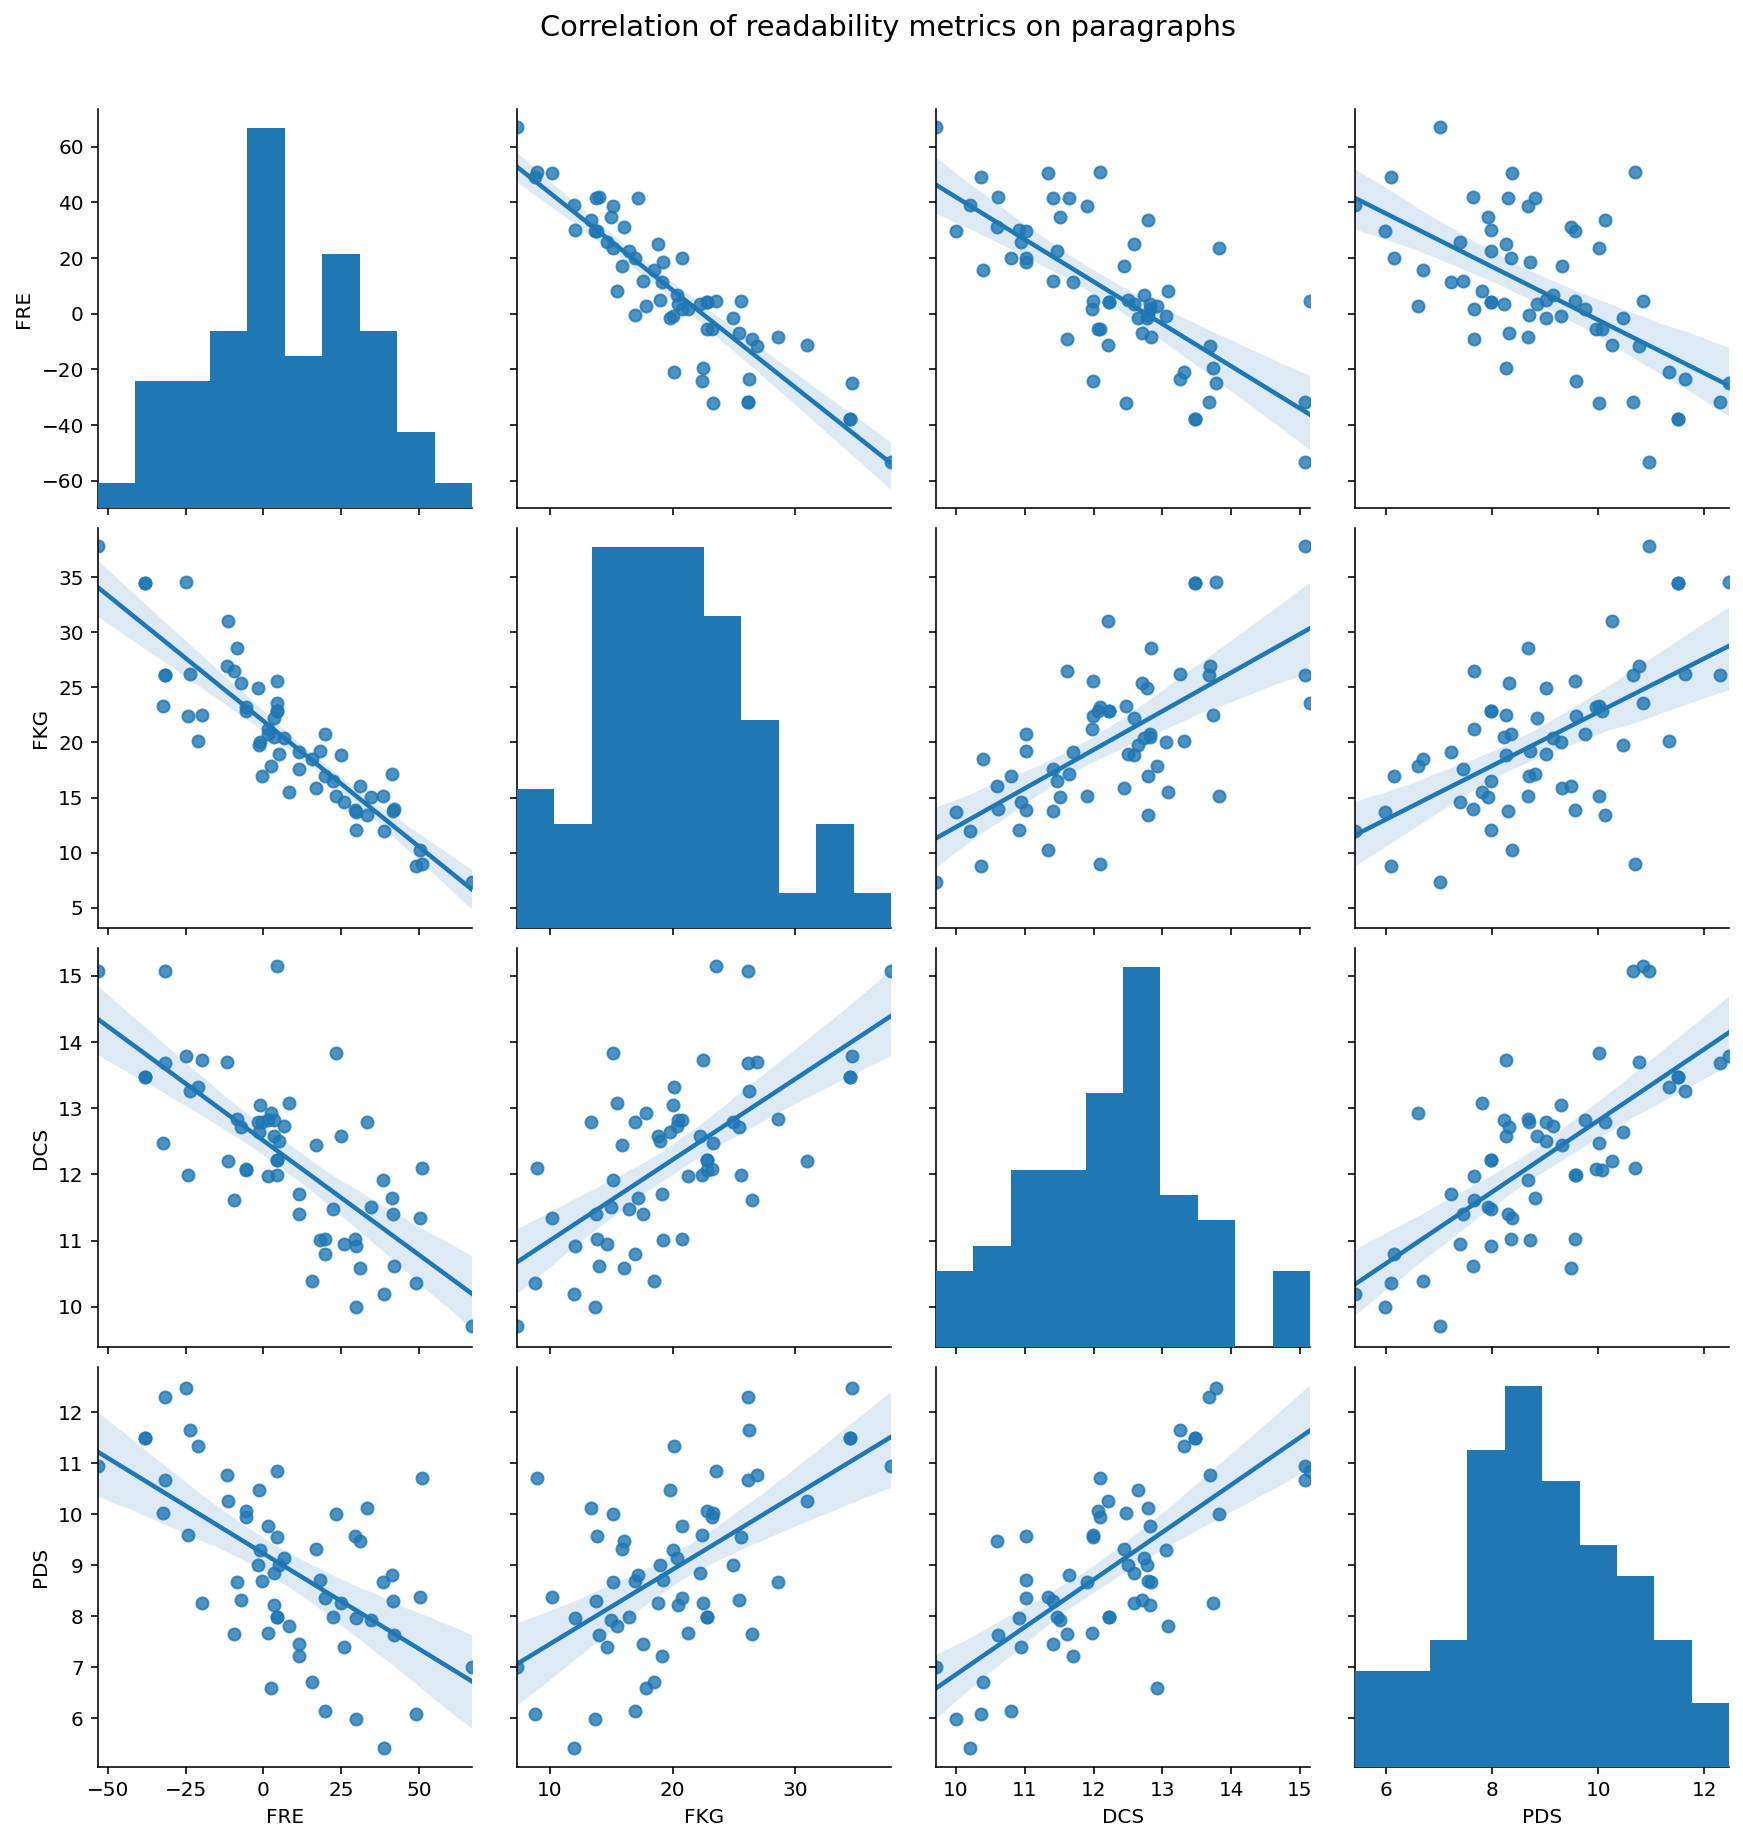

In [12]:
correlate_metrics_graphical(df, 'correlation_metrics.png')